# Variational Autoencoders

In [47]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# --- Sampling layer ---
class Sampling(layers.Layer):
    def call(self, inputs):
        mu, log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(mu))
        return mu + tf.exp(0.5 * log_var) * epsilon

# --- Deep Variational Autoencoder ---
class DeepVAE(Model):
    def __init__(self, latent_dim, input_shape):
        super(DeepVAE, self).__init__()
        self.latent_dim = latent_dim
        self.input_shape_flat = int(tf.reduce_prod(input_shape))  # FIXED

        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
        ])
        self.mu_layer = layers.Dense(latent_dim)
        self.log_var_layer = layers.Dense(latent_dim)
        self.sampler = Sampling()

        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.Dense(64, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(self.input_shape_flat, activation='linear'),
            layers.Reshape(input_shape)
        ])

    def encode(self, x):
        x = self.encoder(x)
        mu = self.mu_layer(x)
        log_var = self.log_var_layer(x)
        z = self.sampler((mu, log_var))
        return mu, log_var, z

    def decode(self, z):
        return self.decoder(z)

    def call(self, x):
        _, _, z = self.encode(x)
        return self.decode(z)

    def compute_loss(self, x):
        mu, log_var, z = self.encode(x)
        x_hat = self.decode(z)
        reconstruction_loss = tf.reduce_mean(tf.square(x - x_hat))  # MSE
        kl_div = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))
        return reconstruction_loss + kl_div


In [48]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phate

# Load CSV files into a DataFrame
file1 = '/Users/amittaris/Documents/GitHub/Dimensionality-Reduction-for-Cellular-Differentiation-/DR notebooks/PHATE/datasets/df_facs_decision1.csv'
df_facs_decision1 = pd.read_csv(file1)

file2 ='/Users/amittaris/Documents/GitHub/Dimensionality-Reduction-for-Cellular-Differentiation-/DR notebooks/PHATE/datasets/df_facs_decision2.csv'
df_facs_decision2 = pd.read_csv(file2)

In [49]:
# Forcefully define valid timepoints
genes = df_facs_decision1.drop(df_facs_decision1.columns[[0,1,7,9,10]], axis=1) 


valid_timepoints_for_1 = [2.0, 2.5, 3.0, 3.5, 4.0, 4.5 , 5.0]
filtered_df = genes[genes['timepoint'].isin(valid_timepoints_for_1)]

cell_types_0 = filtered_df[filtered_df['cluster_post_replacement'].isin([0])]
cell_types_1 = filtered_df[filtered_df['cluster_post_replacement'].isin([1])]
cell_types_2 = filtered_df[filtered_df['cluster_post_replacement'].isin([2])]
cell_types_3 = filtered_df[filtered_df['cluster_post_replacement'].isin([3])]

data = filtered_df.drop(filtered_df.columns[[ 5, 6, 7]], axis=1)
print(data.head())

       TBX6       BRA      CDX2      SOX2      SOX1
0  0.541198  0.228724  1.136731  2.638387  0.676792
1  0.562709  0.153176  1.251472  0.776583  0.694261
2  0.637590  0.240679  1.486664  3.752942  0.682324
3  0.640359  0.184531  1.614646  4.068103  0.828319
4  0.639919  0.153728  1.823096  2.079683  0.990685


In [5]:
# 1) Fit PHATE to your matrix `data` (cells × genes):
phate_op = phate.PHATE(n_landmark=8000, n_components=2, knn=10, decay=20)
phate_coords = phate_op.fit(data[:8000])    # data is (n_cells, n_genes)
P_t = phate_op._calculate_potential(t="auto") # This is P^t



Running PHATE on 8000 observations and 5 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.26 seconds.
  Calculating affinities...
  Calculated affinities in 0.03 seconds.
Calculated graph and diffusion operator in 0.30 seconds.
Calculating optimal t...
  Automatically selected t = 27
Calculated optimal t in 137.97 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 31.19 seconds.


In [ ]:
import numpy as np
import plotly.graph_objects as go

def random_spherical_noise(center, radius, n):
    """Generate random points near a center point on the sphere."""
    noise = []
    for _ in range(n):
        vec = center + 0.15 * np.random.randn(3)  # small 3D Gaussian noise
        vec /= np.linalg.norm(vec)  # reproject onto sphere
        noise.append(vec)
    return np.array(noise)

def generate_branch(start, direction, steps, arc_length):
    """Generate an arc of points along a branch with some spread."""
    tangent = direction / np.linalg.norm(direction)
    arc = []
    for theta in np.linspace(0, arc_length, steps):
        axis = np.cross(start, tangent)
        axis /= np.linalg.norm(axis)

        # Rodrigues rotation
        point = (start * np.cos(theta) +
                 np.cross(axis, start) * np.sin(theta) +
                 axis * np.dot(axis, start) * (1 - np.cos(theta)))
        point /= np.linalg.norm(point)

        # Add local branch noise
        noise = 0.03 * np.random.randn(3)
        noise -= np.dot(noise, point) * point  # remove radial component
        point += noise
        point /= np.linalg.norm(point)
        arc.append(point)
    return np.array(arc)

# Root cluster
root_center = np.array([0, 0, 1])

root_cluster = random_spherical_noise(root_center, radius=1, n=150000)

# Directions for 3 branches
branch_dirs = [
    np.array([1.5, 1.0, -0.5]),
    np.array([-1.0, 1.0, -0.5]),
    np.array([0.5, -1.5, -0.5])
]

branches = []
terminal_clusters = []
branch_labels = []

for i, dir_vec in enumerate(branch_dirs):
    branch = generate_branch(root_center, dir_vec, steps=600, arc_length=np.pi/2)
    branches.append(branch)
    branch_labels.extend([i + 1] * len(branch))

    # Terminal cluster at end of arc
    term_center = branch[-2]
    terminal = random_spherical_noise(term_center, radius=0.1, n=50000)
    terminal_clusters.append(terminal)
    branch_labels.extend([i + 1] * len(terminal))

# Combine all data
X = np.vstack([root_cluster] + branches + terminal_clusters)
labels = np.array([0]*len(root_cluster) + branch_labels)

# Plot
fig = go.Figure(data=go.Scatter3d(
    x=X[:, 0], y=X[:, 1], z=X[:, 2],
    mode='markers',
    marker=dict(
        size=3,
        color=labels,
        colorscale='Viridis',
        opacity=0.9
    )
))
fig.update_layout(
    title='Simulated Differentiation: Root → 3 Branches on Sphere',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)
fig.show()


In [ ]:
X = X.astype(np.float32)
print(X.shape[0:])

(3001800, 3)


In [ ]:
optimizer = tf.keras.optimizers.Adam()
vae = DeepVAE(latent_dim=2, input_shape=X.shape[1:])

@tf.function
def train_step(x):
    with tf.GradientTape() as tape:
        loss = vae.compute_loss(x)
    gradients = tape.gradient(loss, vae.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
    return loss

# Convert X to float32 before training
X = X.astype("float32")

# Training loop
losses = []
for epoch in range(50):
    loss = train_step(X)
    losses.append(loss.numpy())
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy():.4f}")



Epoch 0, Loss: 0.3464
Epoch 10, Loss: 0.2670
Epoch 20, Loss: 0.2648
Epoch 30, Loss: 0.2617
Epoch 40, Loss: 0.2594
Epoch 50, Loss: 0.2577
Epoch 60, Loss: 0.2563
Epoch 70, Loss: 0.2554
Epoch 80, Loss: 0.2549
Epoch 90, Loss: 0.2546


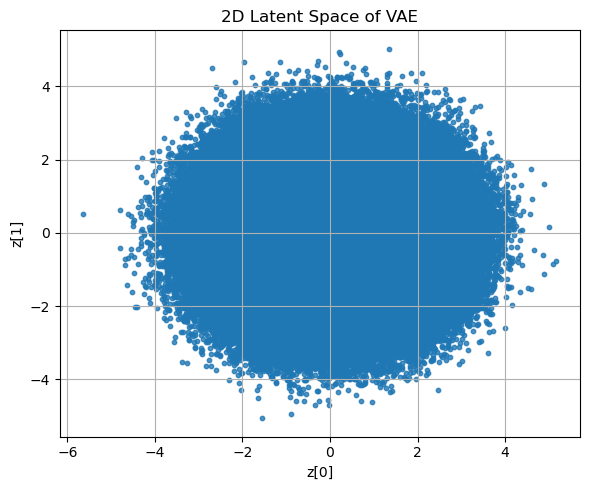

In [ ]:
# Get the latent space representation z
mu, log_var, z = vae.encode(X)  # returns 3 tensors
z_vals = z.numpy()  # shape: (n_samples, 2)

plt.figure(figsize=(6, 5))
plt.scatter(z_vals[:, 0], z_vals[:, 1], s=10, alpha=0.8)
plt.title("2D Latent Space of VAE")
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.grid(True)
plt.tight_layout()
plt.show()


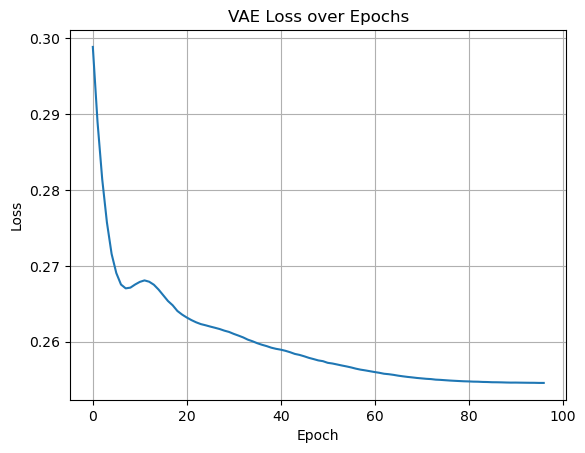

In [ ]:
plt.plot(losses[3:199])
plt.title("VAE Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [ ]:
mu, _, _ = vae.encode(X[:1])
print(mu)
decoded_from_mu = vae.decode(mu)
print("Decoded from μ:", decoded_from_mu.numpy())
print("Original:", X[:1])



tf.Tensor([[-0.00043135 -0.00340305]], shape=(1, 2), dtype=float32)
Decoded from μ: [[0.08308049 0.05587655 0.4881432 ]]
Original: [[-0.04335974  0.2737528   0.9608222 ]]
